In [1]:
import os
import time
import numpy as np
import pickle
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce
#!pip install wget
# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper
#!pip install tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
    """
      Load the data to a pandas dataframe.
      Dataframe Columns:
      title
      para_index
      context
      q_index
      q_id
      q_isimpossible
      q_question
      q_anscount - number of answers
      q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
    """
    result = []
    for pdata in data['data']:
        for para in pdata['paragraphs']:
            for q in para['qas']:
                result.append({
                                'title' : pdata['title'],
                                'context' : para['context'],
                                'q_id' : q['id'],
                                'q_isimpossible' : q['is_impossible'],
                                'q_question' : q['question'],
                                'q_anscount' : len(q['answers']),
                                'q_answers' : [a for a in q['answers']],
                                'q_answers_text': [a.get("text") for a in q['answers']],
                                'context_lowercase': para['context'].lower(),
                                'q_question_lowercase' : q['question'].lower(),
                                'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']]
                               })
    return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
    """
    Download a file from google drive with the shared link
    """ 
    data = load_json_file(filename)
    return convert_to_pd(data)

In [2]:
# DONOT RUN THIS ON COLAB#
#to make use of CPU and not GPU DONOT RUN THIS ON COLAB
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [4]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]

train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [5]:
context_maxlen = 250
question_maxlen = 20
answer_maxlen = 15
ndim = 100
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 250
Max question length: 20
Max answer length: 15


In [6]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
            if i <= num_words:
                vocab[word] = i
        else:
            vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(train_lists)

vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

def calc_answer_span(context,answer):
    
    ans_len = len(answer)
    
    if ans_len!=0 and answer[0] in context:
        indices = [i for i, x in enumerate(context) if x == answer[0]]
        try:
            if(len(indices)>1):
                start = [i for i in indices if (context[i:i+ans_len] == answer) ]
                end = start[0] + ans_len - 1
                return (start[0],end)
            else:
                start = context.index(answer[0])
                end = start + ans_len - 1
                return (start,end)
        except:
            return (-1,-1)
    else:
        return (-1,-1)


def vectorize_data(tokenizer_obj,train_lists):
    qid_original = train_lists[0]
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_span = [calc_answer_span(context_seq[i],answer_seq[i]) for i,x in enumerate(context_seq)]
    answer_start_index = [item[0] for item in answer_span]
    answer_end_index =  [item[1] for item in answer_span]
    answer_start_seq = []
    answer_end_seq = []
    for i,x in enumerate(answer_start_index):
        start = np.zeros(context_maxlen,dtype = "int32")
        end   = np.zeros(context_maxlen,dtype = "int32")
        #last space reserved for the question where there are no answers
        if (answer_start_index[i] < context_maxlen and answer_start_index[i] != -1):
            start[answer_start_index[i]] = 1
        if (answer_end_index[i] < context_maxlen and answer_end_index[i] != -1):
            end[answer_end_index[i]] = 1
        answer_start_seq.append(start)
        answer_end_seq.append(end)
        
    answer_input_seq = [i for i in answer_seq]
    answer_target_seq = answer_input_seq
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    #Adding 0 to last position special for no answer questions
    #context_seq_padded = pad_sequences(context_seq_padded,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    answer_start_seq_padded = pad_sequences(answer_start_seq,context_maxlen,padding='post', truncating='post') 
    answer_end_seq_padded = pad_sequences(answer_end_seq,context_maxlen,padding='post', truncating='post')
    #context_match_question = []
    #for i,a in enumerate(context_seq_padded):
    #    exact = [[1]if ecw in question_seq_padded[i] and ecw !=0 else [0] for ecw in a]
    #    context_match_question.append(exact)
    
    #context_match_question_padded = np.array(context_match_question)
    indices = np.arange(context_seq_padded.shape[0])
    np.random.seed(19)
    np.random.shuffle(indices)
    qid = [qid_original[i] for i in indices]
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible = answer_impossible[indices]
    answer_start_seq_padded = answer_start_seq_padded[indices]
    answer_end_seq_padded = answer_end_seq_padded[indices]
    #context_match_question_padded = context_match_question_padded[indices]
    train_samples = int(((context_seq_padded.shape[0]*.8)//128)*128)
    end_samples = int((context_seq_padded.shape[0]//128)*128)
    train_qid = qid[:train_samples]
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible[:train_samples]
    train_answer_start_seq_padded = answer_start_seq_padded[:train_samples]
    train_answer_end_seq_padded = answer_end_seq_padded[:train_samples]
    #train_context_match_question_padded = context_match_question_padded[:train_samples]
    val_qid = qid[train_samples:end_samples]
    val_context_padded_seq = context_seq_padded[train_samples:end_samples]
    val_question_seq_padded = question_seq_padded[train_samples:end_samples]
    val_answer_seq_padded = answer_seq_padded[train_samples:end_samples]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:end_samples]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:end_samples]
    val_answer_impossible = answer_impossible[train_samples:end_samples]
    val_answer_start_seq_padded = answer_start_seq_padded[train_samples:end_samples]
    val_answer_end_seq_padded = answer_end_seq_padded[train_samples:end_samples]
    #val_context_match_question_padded = context_match_question_padded[train_samples:end_samples]
    return (train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            train_answer_start_seq_padded,train_answer_end_seq_padded,
            #train_context_match_question_padded,
            val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,
            val_answer_start_seq_padded,val_answer_end_seq_padded
            #,val_context_match_question_padded
           )

train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,\
train_answer_start_seq_padded,train_answer_end_seq_padded,\
val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,\
val_answer_start_seq_padded,val_answer_end_seq_padded\
= vectorize_data(tokenizer_obj,train_lists)
print("validation num samples where answer impossible: ",len(val_answer_seq_padded[val_answer_impossible==1]))
print("validation num samples where answer not impossible: ",len(val_answer_seq_padded[val_answer_impossible==0]))
print("train num samples where answer impossible: ",len(train_answer_seq_padded[train_answer_impossible==1]))
print("train num samples where answer not impossible: ",len(train_answer_seq_padded[train_answer_impossible==0]))

Vocab Size: 88701
validation num samples where answer impossible:  8730
validation num samples where answer not impossible:  17382
train num samples where answer impossible:  34761
train num samples where answer not impossible:  69431


In [7]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [8]:
embedding_matrix.shape

(88702, 100)

In [8]:
#New Model with attention in every step of the answer decoder
class BahdanauAttention_model2(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention_model2, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Answer Module which is custom as we need to feed output of each time sequence with attention to next 
# time sequence
class answer_module(tf.keras.Model):
    def __init__(self,embedding_matrix,
                      vocab_size,
                      ndim,
                      num_unit_gru,
                      num_layers_gru,
                      dropout_rate,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(answer_module, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.WSTART = tf.keras.layers.Dense(2*self.num_unit_gru)
        self.WEND = tf.keras.layers.Dense(2*self.num_unit_gru)        
    
    def call(self,
             question,
             context):
        
        context = tf.transpose(context,[0,2,1])
        ################ start prediction logit ######################
        start = self.WSTART(question)
        hidden_start_time_axis = tf.expand_dims(start, 1)
        
        start_logit = tf.squeeze(tf.matmul(hidden_start_time_axis,context),axis=1)
        start_logit = tf.math.exp(start_logit)
            
        ################ end prediction logit ######################
        end = self.WEND(question)

        hidden_end_time_axis = tf.expand_dims(end, 1)
        
        # squeeze remooves time slice we added before
        # final shape = (batch_size,decoder_timesteps)
        end_logit = tf.squeeze(tf.matmul(hidden_end_time_axis,context),axis=1)
        end_logit = tf.math.exp(end_logit)
        
        
        return start_logit,end_logit 

#Encoder Module which combines the context,question into episodic memory and emits context outputs and 
#question outputs
class encoder_module(tf.keras.Model):    
    def __init__(self,embedding_matrix,
                      vocab_size,
                      max_context_length,
                      max_question_length,
                      max_answer_length,
                      num_unit_gru = 64,
                      num_layers_gru = 2,
                      ndim =100,
                      num_episodes = 2,
                      dropout_rate = 0.5,
                      num_episodic_network_unit = 64,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(encoder_module, self).__init__()
        #Context Module
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.num_layers_gru = num_layers_gru
        self.embedding_matrix = embedding_matrix
        self.vocab_size = vocab_size
        self.ndim = ndim
        self.max_context_length = max_context_length
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        self.num_episodes = num_episodes
        self.num_episodic_network_unit = num_episodic_network_unit
        self.context_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                         self.ndim,
                                                         mask_zero=True,
                                                         weights =[self.embedding_matrix],
                                                         trainable = False,
                                                         name='Context_Embedding')
        self.context_output_layers = []
        self.context_batch_normalization_layers = []
        for i in range(self.num_layers_gru):
            self.context_output_layers.append(layers.Bidirectional(
                                                layers.GRU(self.num_unit_gru,
                                                           dropout=self.dropout_rate,
                                                           recurrent_dropout= self.dropout_rate,
                                                           recurrent_initializer='glorot_uniform',
                                                           return_sequences=True,
                                                           kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight),
                                                           bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight)),
                                                           merge_mode='concat',
                                                           name='Context_Bid_Layer'+str(i))
                                              )
            self.context_batch_normalization_layers.append(layers.BatchNormalization())
        
        #Question Module
        self.question_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                          self.ndim,
                                                          mask_zero=True,
                                                          weights =[self.embedding_matrix],
                                                          trainable = False,
                                                          name='Question_Embedding')
          
        self.question_output_layers = []
        self.question_batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.question_output_layers.append(layers.Bidirectional(
                                                 layers.GRU(self.num_unit_gru,
                                                            dropout=self.dropout_rate,
                                                            recurrent_dropout= self.dropout_rate,
                                                            recurrent_initializer='glorot_uniform',
                                                            return_sequences=True,
                                                            kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight),
                                                            bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight)),
                                                             merge_mode='concat',
                                                             name='Question_Bid_Layer'+str(i))
                                              )
            self.question_batch_normalization_layers.append(layers.BatchNormalization())
            
        self.question_attention_layer = layers.Dense(1)
        #Episodic Memory 
        #self.episodic_weight_layer = layers.Dense(self.num_unit_gru,use_bias=False)
        #self.episodic_tanh_layer = layers.Dense(self.num_episodic_network_unit,activation='tanh')
        #self.episodic_score_layer = layers.Dense(1)
        #Self alignment
        self.Align_W1 = tf.keras.layers.Dense(1,activation="relu")
        self.Align_W2 = tf.keras.layers.Dense(1,activation="relu")
    def call(self,context_input,question_input):
        #context Module
        context_embeddings = self.context_embeddings_layer(context_input)
        #Question Module
        question_embeddings = self.question_embeddings_layer(question_input)
        #self alignment
        context_relu = self.Align_W1(context_embeddings)
        question_relu = self.Align_W2(question_embeddings)
        self_align_logits = tf.matmul(context_relu,tf.transpose(question_relu,[0,2,1]))
        self_align_scores = tf.nn.softmax(self_align_logits)
        self_align_embeddings = tf.matmul(self_align_scores,question_embeddings)
        context_concat_embeddings = tf.concat(values=[context_embeddings,self_align_embeddings],axis=-1)
        
        #print("context_embeddings.shape:",context_embeddings.shape)
        #print("question_embeddings.shape:",question_embeddings.shape)
        #print("context_relu.shape:",context_relu.shape)
        #print("question_relu.shape:",question_relu.shape)
        #print("self_align_logits.shape:",self_align_logits.shape)
        #print("self_align_scores.shape:",self_align_scores.shape)
        #print("self_align_embeddings.shape:",self_align_embeddings.shape)
        #print("context_concat_embeddings.shape:",context_concat_embeddings.shape)
        for i in range(len(self.context_output_layers)):
            if i==0:
                context_outputs = self.context_output_layers[i](context_concat_embeddings)
            else:
                context_outputs = self.context_output_layers[i](context_outputs)
            context_outputs = self.context_batch_normalization_layers[i](context_outputs)

        
        for i in range(len(self.question_output_layers)):
            if i==0:
                question_outputs = self.question_output_layers[i](question_embeddings)
            else:
                question_outputs = self.question_output_layers[i](question_outputs)
            question_outputs = self.question_batch_normalization_layers[i](question_outputs) 
        
        #Calculate the self attention for question        
        question_score = self.question_attention_layer(question_outputs)
        # attention_weights shape == (batch_size, max_length, 1)
        question_attention_weights = tf.nn.softmax(question_score, axis=1)
        question_outputs = question_attention_weights * question_outputs
        question_outputs = tf.reduce_sum(question_outputs, axis=1)
        
        #Episodic Memory 
        #m = tf.identity(question_outputs)
        #for i in range(self.num_episodes):
        #    m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    q_increased = tf.tile(tf.keras.backend.expand_dims(question_outputs,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    c_mul_q = layers.multiply([context_outputs,q_increased])
        #    c_mul_m = layers.multiply([context_outputs,m_increased])
        #    c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
        #    c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
        #    c_dot_q = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(question_outputs),1), 
        #                        context_outputs,
        #                        transpose_b=True)
        #    c_dot_q = layers.Permute((2,1))(c_dot_q)
        #    c_dot_m = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(m),1), 
        #                        context_outputs,transpose_b=True)
        #    c_dot_m = layers.Permute((2,1))(c_dot_m)
        #    z = tf.concat([context_outputs,
        #                            m_increased,
        #                            q_increased,
        #                            c_mul_q,
        #                            c_mul_m,
        #                            c_minus_q,
        #                            c_minus_m,
        #                            c_dot_q,
        #                            c_dot_m],axis=-1)
        #    score = self.episodic_score_layer(self.episodic_tanh_layer(z))
        #    attention_weights = tf.nn.softmax(score, axis=1)
        #    m_value = attention_weights * context_outputs
        #    m = tf.reduce_sum(m_value, axis=1)
        #concatenate episodic memory with question
        #concatenated_tensor = tf.concat(values=[m,question_outputs],axis=1)
        return (question_outputs,context_outputs)
    
                
#Function to create the Models
def create_models(embedding_matrix,
                  max_context_length,
                  max_question_length,
                  max_answer_length,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility_units = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  num_episodic_network_unit = 64,
                  l1_regularizer_weight = .01,
                  l2_regularizer_weight = .01):
    """
    
    def create_episodic_memory(num_episodes,
                               query,
                               context_outputs,
                               max_context_length,
                               max_question_length,
                               num_episodic_network_unit):
        m = layers.Lambda(lambda x: x)(query)
        weight_layer = layers.Dense(query.shape[1],use_bias=False)
        for i in range(num_episodes):
            m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            q_increased = tf.tile(tf.keras.backend.expand_dims(query,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            c_mul_q = layers.multiply([context_outputs,q_increased])
            c_mul_m = layers.multiply([context_outputs,m_increased])
            c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
            c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
            c_dot_q = tf.matmul(tf.keras.backend.expand_dims(weight_layer(query),1), 
                                context_outputs,transpose_b=True)
            c_dot_q = layers.Permute((2,1))(c_dot_q)
            c_dot_m = tf.matmul(tf.keras.backend.expand_dims(weight_layer(m),1), 
                                context_outputs,transpose_b=True)
            c_dot_m = layers.Permute((2,1))(c_dot_m)
            z = layers.concatenate([context_outputs,
                                    m_increased,
                                    q_increased,
                                    c_mul_q,
                                    c_mul_m,
                                    c_minus_q,
                                    c_minus_m,
                                    c_dot_q,
                                    c_dot_m],axis=-1)
            score = layers.Dense(1)(layers.Dense(num_episodic_network_unit,activation='tanh')(z))
            attention_weights = tf.nn.softmax(score, axis=1)
            m_value = attention_weights * context_outputs
            m = tf.reduce_sum(m_value, axis=1)
        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,
                                          ndim,
                                          mask_zero=True,
                                          name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                                 dropout=dropout_rate,
                                                                 recurrent_dropout= dropout_rate,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_sequences=True),
                                                      merge_mode='sum',
                                                      name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,
                                           ndim,
                                           mask_zero=True,
                                           name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    #Episodic Memory Module
    m=create_episodic_memory(num_episodes,
                             question_outputs,
                             context_outputs,
                             max_context_length,
                             max_question_length,
                             num_episodic_network_unit)

    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],
                                             name='Concatenation_Memory_Question',axis=1)
    """
    #encoder Model
    encoder_model = encoder_module(embedding_matrix,
                                   vocab_size,
                                   max_context_length,
                                   max_question_length,
                                   max_answer_length,
                                   num_unit_gru,
                                   num_layers_gru,
                                   ndim,
                                   num_episodes,
                                   dropout_rate,
                                   num_episodic_network_unit,
                                   l1_regularizer_weight = l1_regularizer_weight,
                                   l2_regularizer_weight = l2_regularizer_weight
                                 )
    
    
    #Model([context_input,question_input], [m,concatenated_tensor,question_outputs,context_outputs])
    #answer_module
    answer_model = answer_module(embedding_matrix,
                                 vocab_size,
                                 ndim,
                                 num_unit_gru,
                                 num_layers_gru,
                                 dropout_rate,
                                 l1_regularizer_weight = l1_regularizer_weight,
                                 l2_regularizer_weight = l2_regularizer_weight)
    #encoder_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Question_Embedding").trainable = False
    #encoder_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Context_Embedding").trainable = False
    
    #feasibility module
    #feasibility_episodic_memory_input = Input(shape=(num_unit_gru,), name="FeasibilityEpisodicMemoryInput")
    #feasibility_start_logits_input = Input(shape=(max_context_length,),name="FeasibilityStartLogitInput")
    #feasibility_end_logits_input = Input(shape=(max_context_length),name="FeasibilityEndLogitInput")
    feasibility_context_input = Input(shape=(None,2*num_unit_gru,),name='feasibilityContext_Input')
    feasibility_question_input = Input(shape=(2*num_unit_gru,),name='feasibilityQuestion_Input')
    #create attention between Context and Question
    q_with_time_axis = tf.keras.backend.expand_dims(feasibility_question_input,1)
    attentionContextQuestion = layers.AdditiveAttention()([q_with_time_axis,
                                                          feasibility_context_input])
    attentionContextQuestionReduced = tf.keras.backend.sum(attentionContextQuestion, axis=1)
    #create Episodic memory 
    #Episodic Memory 
    episodic_weight_layer = layers.Dense(2*num_unit_gru,use_bias=False)
    episodic_tanh_layer = layers.Dense(num_episodic_network_unit,activation='tanh')
    episodic_score_layer = layers.Dense(1)
    m = tf.identity(feasibility_question_input)
    for i in range(num_episodes):
        m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        q_increased = tf.tile(tf.keras.backend.expand_dims(feasibility_question_input,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        c_mul_q = layers.multiply([feasibility_context_input,q_increased])
        c_mul_m = layers.multiply([feasibility_context_input,m_increased])
        c_minus_q =tf.keras.backend.abs(layers.subtract([feasibility_context_input,q_increased]))
        c_minus_m = tf.keras.backend.abs(layers.subtract([feasibility_context_input,m_increased]))
        c_dot_q = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(feasibility_question_input),1), 
                            feasibility_context_input,
                            transpose_b=True)
        c_dot_q = layers.Permute((2,1))(c_dot_q)
        c_dot_m = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(m),1), 
                            feasibility_context_input,transpose_b=True)
        c_dot_m = layers.Permute((2,1))(c_dot_m)
        z = tf.concat([feasibility_context_input,
                                m_increased,
                                q_increased,
                                c_mul_q,
                                c_mul_m,
                                c_minus_q,
                                c_minus_m,
                                c_dot_q,
                                c_dot_m],axis=-1)
        score = episodic_score_layer(episodic_tanh_layer(z))
        attention_weights = tf.nn.softmax(score, axis=1)
        m_value = attention_weights * feasibility_context_input
        m = tf.reduce_sum(m_value, axis=1)
    
    
    #feasibility_dense_input = tf.concat([m,
    #                                     feasibility_start_logits_input,
    #                                     feasibility_end_logits_input],
    #                                    axis=-1)
    feasibility_dense_input = tf.concat([m,
                                         attentionContextQuestionReduced],
                                        axis=-1)
    for i in range(num_dense_layers_feasibility):        
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(feasibility_dense_input)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',
                                      name='feasibility_output',
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight),
                                      bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight))(dropout_layer)
    feasibility_model = Model([feasibility_question_input,
                               feasibility_context_input],
                               feasibility_output)
    
    return (answer_model,encoder_model,feasibility_model)

In [9]:
#Function to get sentences from the predicted answers
def decode_sentence(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    decoded_sentence = ""
    question_output,context_output = encoder_model(context_input_seq,question_input_seq) 
    
    start_logits,end_logits = answer_model(question_output,context_output)
    
    #Do a outer matrix multiplication of the logits 
    # we need to get the start and end index with highest multiplication of start and end probs
    outer = tf.matmul(tf.expand_dims(start_logits, axis=2),tf.expand_dims(end_logits, axis=0)) 
    outer = tf.linalg.band_part(outer, 0, answer_maxlen)
    start_position = tf.argmax(tf.reduce_max(outer, axis=2),axis=1)    
    end_position = tf.argmax(tf.reduce_max(outer, axis=1),axis=1)
    #print(start_position.shape)
    #print(end_position.shape)
    #print(start_position)
    #print(end_position)
    
    for i in range(start_position[0],end_position[0]+1):
        sampled_token_index = context_input_seq[0,i]
        if sampled_token_index == 0:
            sampled_char = ""
        else:
            sampled_char = id_vocab[sampled_token_index]
        if i == start_position[0]:
            decoded_sentence += sampled_char
        else:
            decoded_sentence += " "+sampled_char
    return decoded_sentence

In [10]:
Experiment_Dic = {'Experiment0': {'num_unit_gru': 64,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment1': {'num_unit_gru': 80,
                                  'num_layers_gru': 3,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 2,
                                  'num_episodic_network_unit': 96,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.0001,
                                  'l2_regularizer_weight':0.01},
                  'Experiment2': {'num_unit_gru': 100,
                                  'num_layers_gru': 2,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment3': {'num_unit_gru': 80,
                                  'num_layers_gru': 4,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment4': {'num_unit_gru': 100,
                                  'num_layers_gru': 3,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 48,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 128,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.001},
                  'Experiment5': {'num_unit_gru': 128,
                                  'num_layers_gru': 3,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment6': {'num_unit_gru': 64,
                                  'num_layers_gru': 4,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 80,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment7': {'num_unit_gru': 128,
                                  'num_layers_gru': 2,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01}
                }
Experiment_Dic

{'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 3,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 2,
  'num_episodic_network_unit': 96,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.0001,
  'l2_regularizer_weight': 0.01},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 1,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 4,


In [11]:
def run_experiments(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
        
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        feasibility_model = create_models(
                                      embedding_matrix = embedding_matrix,
                                      max_context_length = context_maxlen,
                                      max_question_length = question_maxlen,
                                      max_answer_length = answer_maxlen,
                                      num_unit_gru = num_unit_gru,
                                      num_layers_gru = num_layers_gru,
                                      ndim =ndim,
                                      num_episodes = num_episodes,
                                      num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                      dropout_rate = dropout_rate,
                                      num_dense_layers_feasibility = num_dense_layers_feasibility,
                                      num_episodic_network_unit = num_episodic_network_unit,
                                      l1_regularizer_weight = l1_regularizer_weight,
                                      l2_regularizer_weight = l2_regularizer_weight)

        #adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
        #encoder_model.compile(optimizer=adam_optim,
        #                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #encoder_model.summary()
        #answer_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        #                        )
        #
        #answer_model.summary()
        #feasibility_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.BinaryCrossentropy(),
        #                           metrics=[tf.keras.metrics.BinaryAccuracy()]
        #                           )
        #feasibility_model.summary()
    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                     os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = 
                                                        num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                         l1_regularizer_weight = l1_regularizer_weight,
                                         l2_regularizer_weight = l2_regularizer_weight)

            #adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
            #encoder_model.compile(optimizer=adam_optim,
            #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
            #encoder_model.summary()
            #
            #answer_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            #                    )

            #answer_model.summary()
            #feasibility_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.BinaryCrossentropy(),
            #                           metrics=[tf.keras.metrics.BinaryAccuracy()]
            #                           )
            #feasibility_model.summary()
    #Train the Answer Model and Encoder Model
    answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    val_acc_metric = keras.metrics.CategoricalAccuracy()
    @tf.function
    def answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = answer_loss_object(real_start,pred_start)
        end_loss = answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        batch_loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss
            train_acc_metric(targ_start,start_logits)
            train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            answer_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def answer_val_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)
        loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
        batch_loss = loss
        val_acc_metric(targ_start,start_logits)
        val_acc_metric(targ_end,end_logits)
        
        return batch_loss
    #Create batches for training only include where its possible to answer
    #
    #c = b==1
    #a[c][:3]
    train_ans_cond = np.any(train_answer_start_seq_padded == 1,
                            axis=1) & np.any(train_answer_end_seq_padded==1,
                                             axis=1)
    
    #train_answer_impossible==0
    val_ans_cond = np.any(val_answer_start_seq_padded == 1,
                            axis=1) & np.any(val_answer_end_seq_padded==1,
                                             axis=1)
    #val_answer_impossible==0
    #make sure that training samples and validation samples are divisible by 1024
    num_training_samples_upd = int((train_context_padded_seq[train_ans_cond][:num_training_samples].shape[0]//1024)
                                   *1024)
    
    num_validation_samples_upd = int((val_context_padded_seq[val_ans_cond][:num_validation_samples].shape[0]//1024)
                                   *1024)
    TRAIN_BUFFER_SIZE = train_context_padded_seq[train_ans_cond][:num_training_samples_upd].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[val_ans_cond][:num_validation_samples_upd].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[train_ans_cond][:num_training_samples_upd],
                                                        train_question_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_input_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_target_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_impossible[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_start_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_end_seq_padded[train_ans_cond][:num_training_samples_upd]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[val_ans_cond][:num_validation_samples_upd],
                                                      val_question_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_input_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_target_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_impossible[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_start_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_end_seq_padded[val_ans_cond][:num_validation_samples_upd]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    #Run Epochs
    
    history_answer_model = {'loss':[],
                            'categorical_accuracy':[],
                            'val_loss':[],
                            'val_categorical_accuracy':[]}
    print("\nTraining the answer model:")
    #tqdm.write("\nTraining the answer model:")
    #Value to store best validation accuracy
    max_answer_val_accuracy = 0
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        #tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples_upd//batch_size,
                                                             desc="[Training Answer]"):
            batch_loss = answer_train_step(batch_train_context_padded_seq,
                                           batch_train_question_seq_padded,
                                           batch_train_answer_start_seq_padded,
                                           batch_train_answer_end_seq_padded,
                                           encoder_model,
                                           answer_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = train_acc_metric.result()
        print('Epoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples_upd//batch_size,
                                                           desc="[Validating Answer]"):
            batch_loss = answer_val_step(batch_val_context_padded_seq,
                                         batch_val_question_seq_padded,
                                         batch_val_answer_start_seq_padded,
                                         batch_val_answer_end_seq_padded,
                                         encoder_model,
                                         answer_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = val_acc_metric.result()
        print('Epoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_answer_model['loss'].append(epoch_training_loss)
        history_answer_model['categorical_accuracy'].append(epoch_training_accuracy)
        history_answer_model['val_loss'].append(epoch_val_loss)
        history_answer_model['val_categorical_accuracy'].append(epoch_val_accuracy)
        
        #Save only the best model
        if epoch_val_accuracy >= max_answer_val_accuracy:
            max_answer_val_accuracy = epoch_val_accuracy
            answer_model.save_weights('models/'+ ExperimentNo+'span2_model_answer_model.h5')
            encoder_model.save_weights('models/'+ ExperimentNo+'span2_model_encoder_model.h5')
            print('Best Epoch so far! Epoch No {}'.format(epoch + 1))
        
        print('Time taken for epoch {} sec\n'.format(time.time() - start))
        #tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
        
    #answer_model.save_weights('models/'+ ExperimentNo+'span2_model_answer_model.h5')
    #encoder_model.save_weights('models/'+ ExperimentNo+'span2_model_encoder_model.h5')
    with open('models/'+ ExperimentNo+'span2_model_'+'history_answer_model', 'wb') as file_history:
        pickle.dump(history_answer_model, file_history)
        
    
    #Train the Feasibility Model
    #load the best encoder model weights
    encoder_model.load_weights('models/'+ ExperimentNo+'span2_model_encoder_model.h5')
    #Create batches for training including where answer is impossible
    
    TRAIN_BUFFER_SIZE = train_context_padded_seq[:num_training_samples].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[:num_validation_samples].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:num_training_samples],
                                                        train_question_seq_padded[:num_training_samples],
                                                        train_answer_seq_padded[:num_training_samples],
                                                        train_answer_input_seq_padded[:num_training_samples],
                                                        train_answer_target_seq_padded[:num_training_samples],
                                                        train_answer_impossible[:num_training_samples],
                                                        train_answer_start_seq_padded[:num_training_samples],
                                                        train_answer_end_seq_padded[:num_training_samples]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:num_validation_samples],
                                                      val_question_seq_padded[:num_validation_samples],
                                                      val_answer_seq_padded[:num_validation_samples],
                                                      val_answer_input_seq_padded[:num_validation_samples],
                                                      val_answer_target_seq_padded[:num_validation_samples],
                                                      val_answer_impossible[:num_validation_samples],
                                                      val_answer_start_seq_padded[:num_validation_samples],
                                                      val_answer_end_seq_padded[:num_validation_samples]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    feasibility_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feasibility_loss_object = tf.keras.losses.BinaryCrossentropy(reduction='none')
    feasibility_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    feasibility_val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    @tf.function
    def feasibility_loss_function(y_true,y_pred):
        
        loss = feasibility_loss_object(y_true,y_pred)
        return tf.reduce_mean(loss)

    @tf.function
    def feasibility_train_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        batch_loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)        
        with tf.GradientTape() as tape:            
            feasibility_pred = feasibility_model([question_output,
                                                  context_output])
            loss += feasibility_loss_function(feasibility_true,feasibility_pred)
            batch_loss = loss
            feasibility_train_acc_metric(feasibility_true,feasibility_pred)
            variables = feasibility_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            feasibility_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def feasibility_val_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)         
        feasibility_pred = feasibility_model([question_output,
                                              context_output])
        loss += feasibility_loss_function(feasibility_true,feasibility_pred)
        batch_loss = loss
        feasibility_val_acc_metric(feasibility_true,feasibility_pred)
        return batch_loss
    #Run Epochs
    
    history_feasibility_model = {'loss':[],
                            'binary_accuracy':[],
                            'val_loss':[],
                            'val_binary_accuracy':[]}
    print("Training the Feasibility model:")
    #tqdm.write("\nTraining the Feasibility model:")
    #Value to store best validation accuracy
    max_feasibility_val_accuracy = 0
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        #tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples//batch_size,
                                                             desc="[Training Feasibility]"):
            batch_loss = feasibility_train_step(batch_train_context_padded_seq,
                                                batch_train_question_seq_padded,
                                                batch_train_answer_impossible,
                                                encoder_model,
                                                answer_model,
                                                feasibility_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = feasibility_train_acc_metric.result()
        print('Epoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        feasibility_train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples//batch_size,
                                                           desc="[Validating Feasibility]"):
            batch_loss = feasibility_val_step(batch_val_context_padded_seq,
                                              batch_val_question_seq_padded,
                                              batch_val_answer_impossible,
                                              encoder_model,
                                              answer_model,
                                              feasibility_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = feasibility_val_acc_metric.result()
        print('Epoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        feasibility_val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_feasibility_model['loss'].append(epoch_training_loss)
        history_feasibility_model['binary_accuracy'].append(epoch_training_accuracy)
        history_feasibility_model['val_loss'].append(epoch_val_loss)
        history_feasibility_model['val_binary_accuracy'].append(epoch_val_accuracy)
        
        #Save only the best model
        if epoch_val_accuracy >= max_feasibility_val_accuracy:
            max_feasibility_val_accuracy = epoch_val_accuracy
            feasibility_model.save('models/'+ ExperimentNo+'span2_model_feasibility_model.h5')
            print('Best Epoch so far! Epoch No {}'.format(epoch + 1))
        print('Time taken for epoch {} sec\n'.format(time.time() - start))
        #tqdm.write('\nTime taken for epoch {} sec'.format(time.time() - start))
    
    #feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open('models/'+ ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model, file_history)
    
    """
        
    train_question_output,\
    train_context_output = encoder_model(train_context_padded_seq[:num_training_samples],
                                         train_question_seq_padded[:num_training_samples])
    
    train_start_logits,train_end_logits = answer_model(train_question_output,train_context_output)
    
    val_question_output,\
    val_context_output = encoder_model(val_context_padded_seq[:num_validation_samples],
                                                           val_question_seq_padded[:num_validation_samples])
    
    val_start_logits,val_end_logits = answer_model(val_question_output,val_context_output)
    
    
    print("training the feasibility model")
    history_feasibility_model = feasibility_model.fit([train_question_output,
                                                       train_context_output,
                                                       train_start_logits,
                                                       train_end_logits],
                                                      train_answer_impossible[:num_training_samples],
                                                      epochs=num_epochs,
                                                      batch_size=batch_size,
                                                      validation_data = 
                                                            ([val_question_output,
                                                              val_context_output,
                                                              val_start_logits,
                                                              val_end_logits],
                                                             val_answer_impossible[:num_validation_samples])
                                                      )



    feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open(ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model.history, file_history)
    """
    

In [12]:
def create_inference_model(Experiment_Dic,
                           Experiment_No,
                           embedding_matrix,
                           ndim = 100):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                          l1_regularizer_weight = l1_regularizer_weight,
                                          l2_regularizer_weight = l2_regularizer_weight )

    # train on 1 row so that weights can be loaded 
    #Train the Answer Model and Encoder Model
    inference_answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    inference_answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, 
                                                                           reduction='none')
    @tf.function
    def inference_answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = inference_answer_loss_object(real_start,pred_start)
        end_loss = inference_answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def inference_answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += inference_answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss/inp.shape[0]
            #train_acc_metric(targ_start,start_logits)
            #train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            inference_answer_optimizer.apply_gradients(zip(gradients, variables))
            return batch_loss

        
        
    
    
    inference_answer_train_step(train_context_padded_seq[:1],
                              train_question_seq_padded[:1],
                              train_answer_start_seq_padded[:1],
                              train_answer_end_seq_padded[:1],
                              inference_encoder_model,
                              inference_answer_model)
        
    inference_answer_model.load_weights('models/'+ ExperimentNo+'span2_model_answer_model.h5')
    inference_encoder_model.load_weights('models/'+ ExperimentNo+'span2_model_encoder_model.h5')
    inference_feasibility_model.load_weights('models/'+ ExperimentNo+'span2_model_feasibility_model.h5')
    return (inference_answer_model,inference_encoder_model,inference_feasibility_model)

In [13]:
def run_experiments_feasibility(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
        
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        feasibility_model = create_models(
                                      embedding_matrix = embedding_matrix,
                                      max_context_length = context_maxlen,
                                      max_question_length = question_maxlen,
                                      max_answer_length = answer_maxlen,
                                      num_unit_gru = num_unit_gru,
                                      num_layers_gru = num_layers_gru,
                                      ndim =ndim,
                                      num_episodes = num_episodes,
                                      num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                      dropout_rate = dropout_rate,
                                      num_dense_layers_feasibility = num_dense_layers_feasibility,
                                      num_episodic_network_unit = num_episodic_network_unit,
                                      l1_regularizer_weight = l1_regularizer_weight,
                                      l2_regularizer_weight = l2_regularizer_weight)
        
        #load the encoder model weights
        _,_ = encoder_model(train_context_padded_seq[:batch_size],
                            train_question_seq_padded[:batch_size])
        encoder_model.load_weights('models/'+ ExperimentNo+'span2_model_encoder_model.h5')

    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                     os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = 
                                                        num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                         l1_regularizer_weight = l1_regularizer_weight,
                                         l2_regularizer_weight = l2_regularizer_weight)
            
            #load the encoder model weights
            _,_ = encoder_model(train_context_padded_seq[:batch_size],
                                train_question_seq_padded[:batch_size])
            encoder_model.load_weights('models/'+ ExperimentNo+'span2_model_encoder_model.h5')
        
    TRAIN_BUFFER_SIZE = train_context_padded_seq[:num_training_samples].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[:num_validation_samples].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:num_training_samples],
                                                        train_question_seq_padded[:num_training_samples],
                                                        train_answer_seq_padded[:num_training_samples],
                                                        train_answer_input_seq_padded[:num_training_samples],
                                                        train_answer_target_seq_padded[:num_training_samples],
                                                        train_answer_impossible[:num_training_samples],
                                                        train_answer_start_seq_padded[:num_training_samples],
                                                        train_answer_end_seq_padded[:num_training_samples]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:num_validation_samples],
                                                      val_question_seq_padded[:num_validation_samples],
                                                      val_answer_seq_padded[:num_validation_samples],
                                                      val_answer_input_seq_padded[:num_validation_samples],
                                                      val_answer_target_seq_padded[:num_validation_samples],
                                                      val_answer_impossible[:num_validation_samples],
                                                      val_answer_start_seq_padded[:num_validation_samples],
                                                      val_answer_end_seq_padded[:num_validation_samples]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    feasibility_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feasibility_loss_object = tf.keras.losses.BinaryCrossentropy(reduction='none')
    feasibility_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    feasibility_val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    @tf.function
    def feasibility_loss_function(y_true,y_pred):
        
        loss = feasibility_loss_object(y_true,y_pred)
        return tf.reduce_mean(loss)

    @tf.function
    def feasibility_train_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        batch_loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)        
        with tf.GradientTape() as tape:            
            feasibility_pred = feasibility_model([question_output,
                                                  context_output])
            loss += feasibility_loss_function(feasibility_true,feasibility_pred)
            batch_loss = loss
            feasibility_train_acc_metric(feasibility_true,feasibility_pred)
            variables = feasibility_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            feasibility_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def feasibility_val_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)         
        feasibility_pred = feasibility_model([question_output,
                                              context_output])
        loss += feasibility_loss_function(feasibility_true,feasibility_pred)
        batch_loss = loss
        feasibility_val_acc_metric(feasibility_true,feasibility_pred)
        return batch_loss
    #Run Epochs
    
    history_feasibility_model = {'loss':[],
                            'binary_accuracy':[],
                            'val_loss':[],
                            'val_binary_accuracy':[]}
    print("Training the Feasibility model:")
    #tqdm.write("\nTraining the Feasibility model:")
    #Value to store best validation accuracy
    max_feasibility_val_accuracy = 0
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        #tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples//batch_size,
                                                             desc="[Training Feasibility]"):
            batch_loss = feasibility_train_step(batch_train_context_padded_seq,
                                                batch_train_question_seq_padded,
                                                batch_train_answer_impossible,
                                                encoder_model,
                                                answer_model,
                                                feasibility_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = feasibility_train_acc_metric.result()
        print('Epoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        feasibility_train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples//batch_size,
                                                           desc="[Validating Feasibility]"):
            batch_loss = feasibility_val_step(batch_val_context_padded_seq,
                                              batch_val_question_seq_padded,
                                              batch_val_answer_impossible,
                                              encoder_model,
                                              answer_model,
                                              feasibility_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = feasibility_val_acc_metric.result()
        print('Epoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        feasibility_val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_feasibility_model['loss'].append(epoch_training_loss)
        history_feasibility_model['binary_accuracy'].append(epoch_training_accuracy)
        history_feasibility_model['val_loss'].append(epoch_val_loss)
        history_feasibility_model['val_binary_accuracy'].append(epoch_val_accuracy)
        
        #Save only the best model
        if epoch_val_accuracy >= max_feasibility_val_accuracy:
            max_feasibility_val_accuracy = epoch_val_accuracy
            feasibility_model.save('models/'+ ExperimentNo+'span2_model_feasibility_model.h5')
            print('Best Epoch so far! Epoch No {}'.format(epoch + 1))
        with open('models/'+ ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
          pickle.dump(history_feasibility_model, file_history)
        print('Time taken for epoch {} sec\n'.format(time.time() - start))
        #tqdm.write('\nTime taken for epoch {} sec'.format(time.time() - start))
    
    #feasibility_model.save(ExperimentNo+'span2_model_feasibility_model.h5')
    with open('models/'+ ExperimentNo+'span2_model_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model, file_history)

In [15]:
#Run Experiments
#change the num_training_samples and num_validation_samples make sure its multiple of 128 when running on tpu
#change to tpu_enabled = 1 when running on tpu 
#Change the batch_size and epochs too

#--Create a list of expt indices to run
expts_to_run = [5, 7]

#for i in range(8):
for i in expts_to_run:
    tpu_enabled_flag = 0
    if tpu_enabled_flag ==0:
        number_of_epochs = 25
    else:
        number_of_epochs = 35
    run_experiments_feasibility(Experiment_Dic=Experiment_Dic,
                Experiment_No=i,
                embedding_matrix=embedding_matrix,
                ndim = ndim,
                tpu_enabled=tpu_enabled_flag,
                num_training_samples=1024*60,
                num_validation_samples = 1024*6,
                num_epochs = number_of_epochs,
                batch_size = 128)

Running  Experiment5


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6504 Train Accuracy 0.6630


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 1 - Validation Loss 0.6396 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 1
Time taken for epoch 762.5500700473785 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6365 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 2 - Validation Loss 0.6394 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 2
Time taken for epoch 727.6108391284943 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6361 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 3 - Validation Loss 0.6385 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 3
Time taken for epoch 701.4951679706573 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6355 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 4 - Validation Loss 0.6397 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 4
Time taken for epoch 700.2242052555084 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6350 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 5 - Validation Loss 0.6380 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 5
Time taken for epoch 700.851282119751 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.6349 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 6 - Validation Loss 0.6388 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 6
Time taken for epoch 701.5476241111755 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.6343 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 0.6409 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 7
Time taken for epoch 700.4226369857788 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.6347 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 0.6389 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 8
Time taken for epoch 700.0062668323517 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.6341 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6373 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 9
Time taken for epoch 692.6861138343811 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.6332 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 0.6368 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 10
Time taken for epoch 692.3200440406799 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.6327 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 0.6365 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 11
Time taken for epoch 695.9702098369598 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.6325 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 0.6362 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 12
Time taken for epoch 686.1765999794006 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.6321 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6374 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 13
Time taken for epoch 683.9182918071747 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.6324 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6364 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 14
Time taken for epoch 688.899423122406 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.6321 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6368 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 15
Time taken for epoch 687.27290391922 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.6320 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6357 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 16
Time taken for epoch 689.4447240829468 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.6322 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6355 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 17
Time taken for epoch 684.327320098877 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.6321 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6357 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 18
Time taken for epoch 685.2314958572388 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.6317 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6365 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 19
Time taken for epoch 687.2810380458832 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.6316 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6360 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 20
Time taken for epoch 686.9463322162628 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.6313 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.6384 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 21
Time taken for epoch 690.9072229862213 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.6313 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6351 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 22
Time taken for epoch 686.7847399711609 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.6314 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6349 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 23
Time taken for epoch 692.0424280166626 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.6309 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6355 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 24
Time taken for epoch 693.2598431110382 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.6314 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:52<00:00,  1.10s/it]


Epoch 25 - Validation Loss 0.6360 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 25
Time taken for epoch 689.2009949684143 sec

Running  Experiment7


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6189 Train Accuracy 0.6679


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 1 - Validation Loss 0.6128 Validation Accuracy 0.6621
Best Epoch so far! Epoch No 1
Time taken for epoch 473.7616891860962 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6030 Train Accuracy 0.6756


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 2 - Validation Loss 0.6101 Validation Accuracy 0.6629
Best Epoch so far! Epoch No 2
Time taken for epoch 463.5629060268402 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.5907 Train Accuracy 0.6828


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 3 - Validation Loss 0.5996 Validation Accuracy 0.6759
Best Epoch so far! Epoch No 3
Time taken for epoch 465.6622459888458 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.5800 Train Accuracy 0.6904


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 4 - Validation Loss 0.6036 Validation Accuracy 0.6761
Best Epoch so far! Epoch No 4
Time taken for epoch 465.86762714385986 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.5707 Train Accuracy 0.6975


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 5 - Validation Loss 0.6022 Validation Accuracy 0.6797
Best Epoch so far! Epoch No 5
Time taken for epoch 466.7541298866272 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.5598 Train Accuracy 0.7035


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 6 - Validation Loss 0.6016 Validation Accuracy 0.6722
Time taken for epoch 468.18519496917725 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.5498 Train Accuracy 0.7124


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 0.6115 Validation Accuracy 0.6650
Time taken for epoch 467.03745698928833 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.5394 Train Accuracy 0.7162


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 0.6166 Validation Accuracy 0.6730
Time taken for epoch 464.17441034317017 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.5304 Train Accuracy 0.7224


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6339 Validation Accuracy 0.6740
Time taken for epoch 464.2130401134491 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.5179 Train Accuracy 0.7301


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 0.6213 Validation Accuracy 0.6712
Time taken for epoch 461.480917930603 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.5077 Train Accuracy 0.7373


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 0.6417 Validation Accuracy 0.6592
Time taken for epoch 458.24115085601807 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.4990 Train Accuracy 0.7408


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 0.6413 Validation Accuracy 0.6590
Time taken for epoch 467.0276870727539 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.4879 Train Accuracy 0.7507


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6580 Validation Accuracy 0.6639
Time taken for epoch 464.68423676490784 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.4793 Train Accuracy 0.7561


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6761 Validation Accuracy 0.6452
Time taken for epoch 466.2615029811859 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.4691 Train Accuracy 0.7606


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6871 Validation Accuracy 0.6439
Time taken for epoch 459.1997916698456 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.4589 Train Accuracy 0.7680


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6991 Validation Accuracy 0.6359
Time taken for epoch 460.99501490592957 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.4508 Train Accuracy 0.7722


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.7050 Validation Accuracy 0.6549
Time taken for epoch 457.07910108566284 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.4414 Train Accuracy 0.7792


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.7420 Validation Accuracy 0.6436
Time taken for epoch 466.06181383132935 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.4323 Train Accuracy 0.7830


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.7332 Validation Accuracy 0.6424
Time taken for epoch 460.9683451652527 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.4247 Train Accuracy 0.7886


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.7426 Validation Accuracy 0.6406
Time taken for epoch 468.1938307285309 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.4165 Train Accuracy 0.7937


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.7749 Validation Accuracy 0.6341
Time taken for epoch 463.5161671638489 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.4098 Train Accuracy 0.7971


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.7791 Validation Accuracy 0.6377
Time taken for epoch 463.6181089878082 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.4017 Train Accuracy 0.8029


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.7973 Validation Accuracy 0.6410
Time taken for epoch 464.41433119773865 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.3936 Train Accuracy 0.8086


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.8036 Validation Accuracy 0.6418
Time taken for epoch 461.02091002464294 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.3884 Train Accuracy 0.8119


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]


Epoch 25 - Validation Loss 0.8166 Validation Accuracy 0.6178
Time taken for epoch 466.4885377883911 sec



In [ ]:
#Run Inference
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=5,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)

In [ ]:
#Some Examples from Training Set
for seq_index in range(500,510):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    question_output,context_output = inference_encoder_model(context_input_seq,question_input_seq)
    #start_logits,end_logits = inference_answer_model(question_output,context_output)         
    feasibility_pred = inference_feasibility_model.predict([question_output,
                                                            context_output])
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print("Question Infeasible to answer prediction:",feasibility_pred)
    print("Question Infeasible to answer actual value",train_answer_impossible[seq_index: seq_index+ 1])
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

In [ ]:
#Some examples from validation set
for seq_index in range(800,810):
    # Take one sequence (part of the Validation test)
    # for trying out decoding.
    context_input_seq = val_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = val_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    question_output,context_output = inference_encoder_model(context_input_seq,question_input_seq)
    #start_logits,end_logits = inference_answer_model(question_output,context_output)         
    feasibility_pred = inference_feasibility_model.predict([question_output,
                                                            context_output])
    print("question:",' '.join([id_vocab.get(i) for i in val_question_seq_padded[seq_index].tolist() if i !=0]))
    print("Question Infeasible to answer prediction:",feasibility_pred)
    print("Question Infeasible to answer actual value",val_answer_impossible[seq_index: seq_index+ 1])
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in val_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

In [ ]:
def plot_experiments(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists('models/'+ ExperimentNo+'span2_model_'+'history_feasibility_model') 
       and os.path.exists('models/'+ ExperimentNo+'span2_model_'+'history_answer_model') ) :
        with open('models/'+ ExperimentNo+'span2_model_'+'history_feasibility_model', 'rb') as file_history:
            feasibility_history = pickle.load( file_history )

        with open('models/'+ ExperimentNo+'span2_model_'+'history_answer_model', 'rb') as file_history:
            answer_history = pickle.load( file_history )

        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('++++++++++++++++++++++++'+ExperimentNo+'++++++++++++++++++++++',fontsize=14)
        
        #plot Answer Module
        # Plot training & validation accuracy values
        axs[0, 0].plot(answer_history['categorical_accuracy'])
        axs[0, 0].plot(answer_history['val_categorical_accuracy'])
        axs[0, 0].set_title(ExperimentNo+' Answer Model accuracy')
        axs[0, 0].set_ylabel('Categorical Cross Entropy Accuracy')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[0, 1].plot(answer_history['loss'])
        axs[0, 1].plot(answer_history['val_loss'])
        axs[0, 1].set_title(ExperimentNo+' Answer Model loss')
        axs[0, 1].set_ylabel('Categorical Cross Entropy Loss')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()


        #plot Feasibility Module
        # Plot training & validation accuracy values
        axs[1, 0].plot(feasibility_history['binary_accuracy'])
        axs[1, 0].plot(feasibility_history['val_binary_accuracy'])
        axs[1, 0].set_title(ExperimentNo+' Feasibility Model accuracy')
        axs[1, 0].set_ylabel('Binary Cross Entropy Accuracy')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[1, 1].plot(feasibility_history['loss'])
        axs[1, 1].plot(feasibility_history['val_loss'])
        axs[1, 1].set_title(ExperimentNo+' Feasibility Model loss')
        axs[1, 1].set_ylabel('Binary Cross Entropy Loss')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()
        
        plt.savefig('graphs/{}_span2_model_.png'.format(ExperimentNo))

In [ ]:
#for i in range (8):
for i in expts_to_run:
    plot_experiments(i)

In [38]:
def plot_experiment_results():
    answer_accuracy_list = []
    feasibility_accuracy_list = []
    
    for i in range(8):
        
        ExperimentNo = "Experiment"+str(i)
        if ( os.path.exists('models/'+ ExperimentNo+'span2_model_'+'history_feasibility_model') 
            and os.path.exists('models/'+ ExperimentNo+'span2_model_'+'history_answer_model') ) :
            
            with open('models/'+ ExperimentNo+'span2_model_'+'history_feasibility_model', 'rb') as file_history:
                feasibility_history = pickle.load( file_history )

            with open('models/'+ ExperimentNo+'span2_model_'+'history_answer_model', 'rb') as file_history:
                answer_history = pickle.load( file_history )

            answer_accuracy_list.append(max(answer_history['val_categorical_accuracy']))
            feasibility_accuracy_list.append(max(feasibility_history['val_binary_accuracy']))

    #plt.plot(answer_accuracy_list,marker='^')
    #plt.plot(feasibility_accuracy_list,marker='*')
    #plt.ylabel("Validation Accuracy")
    #plt.xlabel("Experiment Number")
    #plt.title("LSTM based models experiments result")

    fig, axs = plt.subplots(1, 2,figsize=(15,6))

    #plot Answer Module results
    axs[0].plot(answer_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[0].set_title("Model-3 based answer model experiments")
    axs[0].set_ylabel('Validation Accuracy')
    axs[0].set_xlabel('Experiment Number')

    #plot feasibility Module results

    axs[1].plot(feasibility_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[1].set_title("Model-3 based feasibility model experiments")
    axs[1].set_ylabel('Validation Accuracy')
    axs[1].set_xlabel('Experiment Number')
    
    #plt.show()
    plt.savefig('graphs/expt_results2_span2_model_.png')

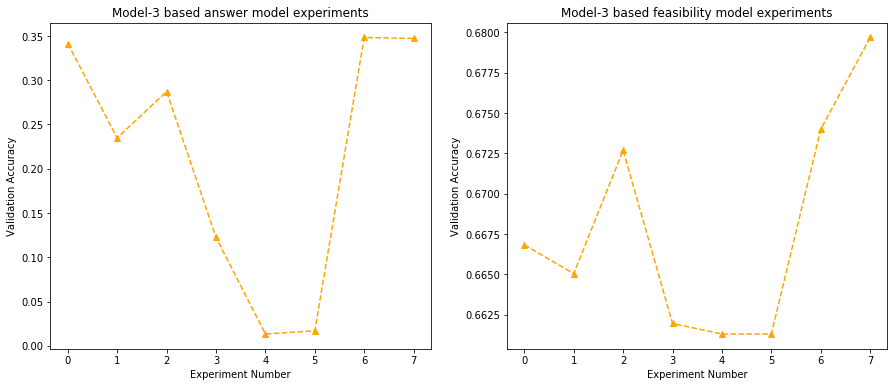

In [39]:
plot_experiment_results()

In [40]:
#create inference models for all the experiments 
for epno in range(8):
    #Create Inference model
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=epno,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)
    #check if the validation file exists 
    ExperimentNo = "Experiment"+str(epno)
    if not os.path.exists('models/'+ ExperimentNo+'span2_model_'+'feasibility_val_pred.npy'):
        
        #create validation set for the feasibility module: 
        VAL_BUFFER_SIZE = val_context_padded_seq.shape[0]
        batch_size = 128
        steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size + 1
        val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:VAL_BUFFER_SIZE],
                                                              val_question_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_input_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_target_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_impossible[:VAL_BUFFER_SIZE],
                                                              val_answer_start_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_end_seq_padded[:VAL_BUFFER_SIZE]
                                                             ))
        val_dataset = val_dataset.batch(batch_size,drop_remainder=False)

        i=0
        for (batch, (batch_val_context_padded_seq,
                             batch_val_question_seq_padded,
                             batch_val_answer_seq_padded,
                             batch_val_answer_input_seq_padded,
                             batch_val_answer_target_seq_padded,
                             batch_val_answer_impossible,
                             batch_val_answer_start_seq_padded,
                             batch_val_answer_end_seq_padded)) in tqdm(
                                                    enumerate(val_dataset.take(steps_per_epoch_val)),
                                                    total = VAL_BUFFER_SIZE//batch_size+1,
                                                    desc="[Creating Validation Ferasibility Prediction]"):
            question_output,context_output = inference_encoder_model(batch_val_context_padded_seq,
                                                                   batch_val_context_padded_seq)
            feasibility_pred = inference_feasibility_model([question_output,
                                                            context_output])
            if i==0:
                feasibility_validation_prediction = feasibility_pred.numpy()
            else:
                feasibility_validation_prediction = np.concatenate((feasibility_validation_prediction,
                                                                    feasibility_pred.numpy()),axis=0)
            i += 1
        #save the feasibility_validation_prediction
        np.save('models/'+ ExperimentNo+'span2_model_'+'feasibility_val_pred',feasibility_validation_prediction)


[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [22:14<00:06,  6.54s/it]


[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [24:32<00:07,  7.22s/it]


[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [27:40<00:08,  8.14s/it]


In [42]:
#!pip install -U scikit-learn
#!pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
""" Following function taken from : 
    https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
"""
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in long_scalars


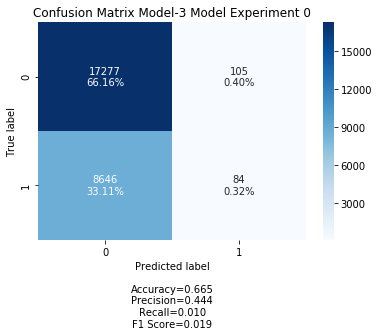

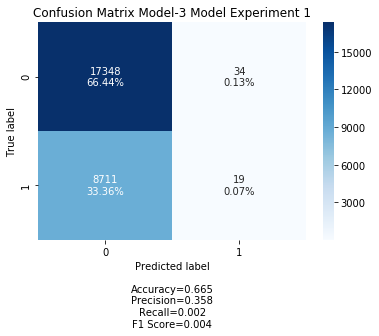

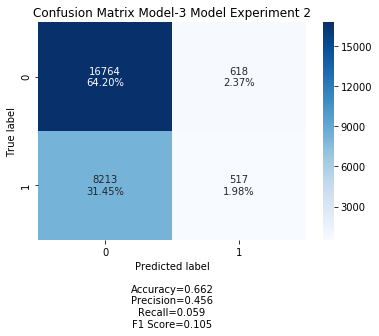

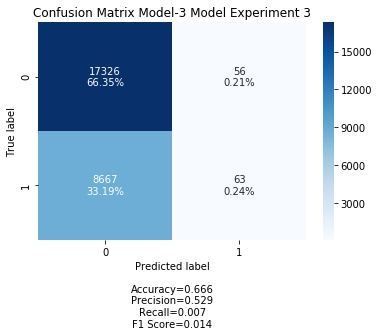

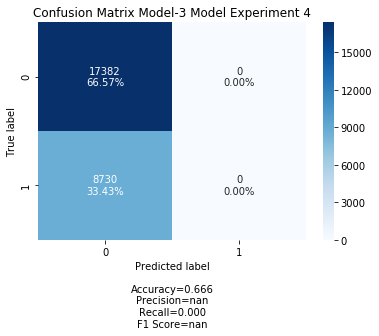

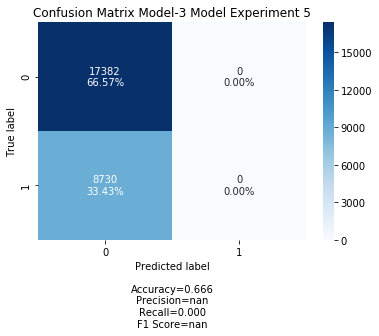

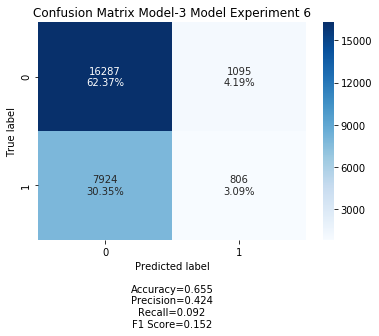

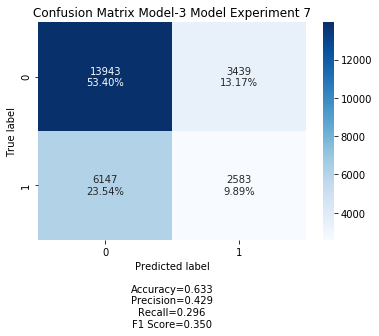

In [44]:
#plot confusion matrix for the feasibility model output for each experiment 

for i in range(8):
    #load feasibility predictions
    ExperimentNo = "Experiment"+str(i)
    if os.path.exists('models/'+ ExperimentNo+'span2_model_'+'feasibility_val_pred.npy'):
        y_pred_prob = np.load('models/'+ ExperimentNo+'span2_model_'+'feasibility_val_pred.npy')
        y_pred = (y_pred_prob>0.5).astype(int)
        #Get the confusion matrix
        cf_matrix = confusion_matrix(val_answer_impossible, y_pred)
        #print(cf_matrix)
        make_confusion_matrix(cf_matrix,title = 'Confusion Matrix Model-3 Model Experiment '+str(i))
        
    

In [45]:
#Function to get sentences from the predicted answers
def decode_sentence_batch(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    #decoded_sentence = ""
    question_output,context_output = encoder_model(context_input_seq,question_input_seq) 
    
    start_logits,end_logits = answer_model(question_output,context_output)
    
    #Do a outer matrix multiplication of the logits 
    # we need to get the start and end index with highest multiplication of start and end probs
    outer = tf.matmul(tf.expand_dims(start_logits, axis=2),tf.expand_dims(end_logits, axis=1)) 
    outer = tf.linalg.band_part(outer, 0, answer_maxlen)
    start_position = tf.argmax(tf.reduce_max(outer, axis=2),axis=1)    
    end_position = tf.argmax(tf.reduce_max(outer, axis=1),axis=1)
    #start_position = start_position.numpy()
    #end_position = end_position.numpy()
    #print(start_position.shape)
    #print(end_position.shape)
    #print(start_position)
    #print(end_position)
    decoded_sentences_batch = []
    for j in range(question_input_seq.shape[0]):
        decoded_sentence = ''
        for i in range(start_position[j],end_position[j]+1):
            sampled_token_index = context_input_seq[j,i].numpy()
            #print(sampled_token_index)
            if sampled_token_index == 0:
                sampled_char = ""
            else:
                sampled_char = id_vocab[sampled_token_index]
            if i == start_position[j]:
                decoded_sentence += sampled_char
            else:
                decoded_sentence += " "+sampled_char
        decoded_sentences_batch.append(decoded_sentence)
    
    return decoded_sentences_batch

In [46]:
#genarate answers for the questions from the answer model
#create inference models for all the experiments 
for epno in range(8):
    #Create Inference model
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=epno,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)
    #check if the validation file exists 
    ExperimentNo = "Experiment"+str(epno)
    if ( not os.path.exists('models/'+ ExperimentNo+'span2_model_'+'answer_val_pred')
        and os.path.exists('models/'+ ExperimentNo+'span2_model_'+'feasibility_val_pred.npy')):
        
        y_pred_prob = np.load('models/'+ ExperimentNo+'span2_model_'+'feasibility_val_pred.npy')
        y_pred = (y_pred_prob>0.5).astype(int)
        #create dictionary to store the predicted answer
        val_predicted_answer_dic = {}
        #create list to store the answers
        val_predicted_answer = []
        #create validation set for the feasibility module: 
        VAL_BUFFER_SIZE = val_context_padded_seq.shape[0]
        batch_size = 128
        steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size + 1
        val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:VAL_BUFFER_SIZE],
                                                              val_question_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_input_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_target_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_impossible[:VAL_BUFFER_SIZE],
                                                              val_answer_start_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_end_seq_padded[:VAL_BUFFER_SIZE]
                                                             ))
        val_dataset = val_dataset.batch(batch_size,drop_remainder=False)

        i=0
        for (batch, (batch_val_context_padded_seq,
                             batch_val_question_seq_padded,
                             batch_val_answer_seq_padded,
                             batch_val_answer_input_seq_padded,
                             batch_val_answer_target_seq_padded,
                             batch_val_answer_impossible,
                             batch_val_answer_start_seq_padded,
                             batch_val_answer_end_seq_padded)) in tqdm(
                                                    enumerate(val_dataset.take(steps_per_epoch_val)),
                                                    total = VAL_BUFFER_SIZE//batch_size+1,
                                                    desc="[Creating Validation Ferasibility Prediction]"):
            answers = decode_sentence_batch(batch_val_context_padded_seq,
                                            batch_val_question_seq_padded,
                                            inference_encoder_model,
                                            inference_answer_model)
            val_predicted_answer = val_predicted_answer + answers
        
        for c,(qid,answer) in enumerate(zip(val_qid[:VAL_BUFFER_SIZE],val_predicted_answer)):
            if y_pred[c] == 0 :
                val_predicted_answer_dic[qid] = answer
            else:
                val_predicted_answer_dic[qid] =  ''
        #save the answer_prediction
        with open('models/'+ ExperimentNo+'span2_model_'+'answer_val_pred', 'w') as file_answer_prediction:
            file_answer_prediction.write(json.dumps(val_predicted_answer_dic))

[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [14:43<00:04,  4.33s/it]


In [47]:
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys
def normalize_answer(s):
       
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))
def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def get_raw_scores(dataset, preds,only_answerable_questions):
    exact_scores = {}
    f1_scores = {}
    for article in dataset:
        for p in article['paragraphs']:
            for qa in p['qas']:
                qid = qa['id']
                gold_answers = [a['text'] for a in qa['answers']
                                if normalize_answer(a['text'])]
                if gold_answers or not only_answerable_questions:
                    if not gold_answers:
                        # For unanswerable questions, only correct answer is empty string
                        gold_answers = ['']
                    if qid not in preds:
                        #print('Missing prediction for %s' % qid)
                        continue
                    a_pred = preds[qid]
                    # Take max over all gold answers
                    exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
                    f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
    return exact_scores, f1_scores

def calculate_f1(dataset_file_name,prediction_file_name,only_answerable_questions=False):
    with open(dataset_file_name) as f:
        dataset_json = json.load(f)
        dataset = dataset_json['data']
    with open(prediction_file_name) as f:
        preds = json.load(f)
    exact_raw, f1_raw = get_raw_scores(dataset, preds,only_answerable_questions)
    total = len(exact_raw)
    return collections.OrderedDict([
                                    ('exact', 100.0 * sum(exact_raw.values()) / total),
                                    ('f1', 100.0 * sum(f1_raw.values()) / total),
                                    ('total', total),
                                   ])
    #return exact_raw, f1_raw

In [49]:
f1_score = []
f1_score_only_answerable = []
for epno in range(8):
    ExperimentNo = "Experiment"+str(epno)
    g1 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'models/Experiment6span2_model_answer_val_pred',
                 only_answerable_questions=True)
    g2 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'models/Experiment6span2_model_answer_val_pred',
                 only_answerable_questions=False)
    f1_score.append(g1['f1'])
    f1_score_only_answerable.append(g2['f1'])


In [62]:
def plot_experiment_results_all():
    answer_accuracy_list = []
    feasibility_accuracy_list = []
    f1_score = []
    f1_score_only_answerable = []
    for i in range(8):
        
        ExperimentNo = "Experiment"+str(i)
        if ( os.path.exists('models/' + ExperimentNo+'span2_model_'+'history_feasibility_model') 
            and os.path.exists('models/' + ExperimentNo+'span2_model_'+'history_answer_model') ) :
            
            with open('models/' + ExperimentNo+'span2_model_'+'history_feasibility_model', 'rb') as file_history:
                feasibility_history = pickle.load( file_history )

            with open('models/' + ExperimentNo+'span2_model_'+'history_answer_model', 'rb') as file_history:
                answer_history = pickle.load( file_history )

            answer_accuracy_list.append(max(answer_history['val_categorical_accuracy']))
            feasibility_accuracy_list.append(max(feasibility_history['val_binary_accuracy']))
        g1 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'models/' + ExperimentNo+'span2_model_answer_val_pred',
                 only_answerable_questions=True)
        g2 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'models/' + ExperimentNo+'span2_model_answer_val_pred',
                 only_answerable_questions=False)
        f1_score.append(g2['f1'])
        f1_score_only_answerable.append(g1['f1'])

    #plt.plot(answer_accuracy_list,marker='^')
    #plt.plot(feasibility_accuracy_list,marker='*')
    #plt.ylabel("Validation Accuracy")
    #plt.xlabel("Experiment Number")
    #plt.title("LSTM based models experiments result")

    fig, axs = plt.subplots(1, 3,figsize=(15,6))

    #plot Answer Module results
    axs[0].plot(answer_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[0].set_title("Model-3 based answer model experiments")
    axs[0].set_ylabel('Validation Accuracy')
    axs[0].set_xlabel('Experiment Number')

    #plot feasibility Module results

    axs[1].plot(feasibility_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[1].set_title("Model-3 based feasibility model experiments")
    axs[1].set_ylabel('Validation Accuracy')
    axs[1].set_xlabel('Experiment Number')
    #plt.show()
    axs[2].plot(f1_score,marker='^',linestyle='dashed',color='orange')
    axs[2].plot(f1_score_only_answerable,marker='o',linestyle='dashed',color='blue')
    axs[2].legend(['All Qtns', 'Only Answerable Qtns'], loc='lower right')
    axs[2].set_title("Model-3 based model F1 Score")
    axs[2].set_ylabel('Validation F1 Score')
    axs[2].set_xlabel('Experiment Number')
    
    plt.savefig('graphs/expt2_results_span2_model_.png')

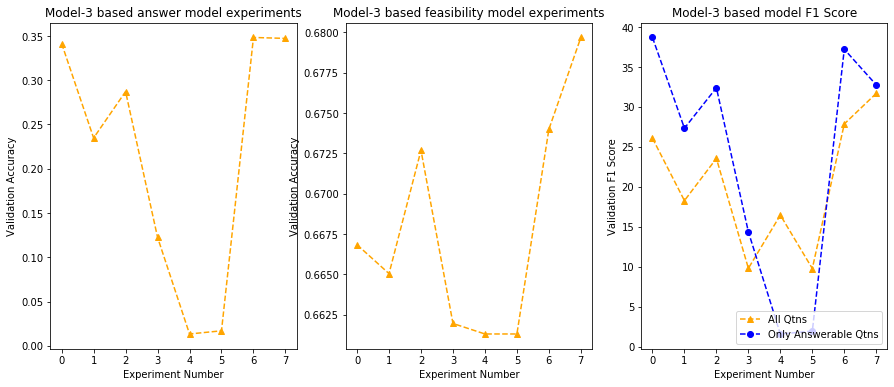

In [63]:
plot_experiment_results_all()

In [66]:
#Some examples from validation set from experiment6
with open('models/Experiment6span2_model_answer_val_pred') as f:
    k = json.load(f)
for seq_index in range(100,132):
    # Take one sequence (part of the Validation test)
    # for trying out decoding.
    qid = val_qid[seq_index]
    question = ' '.join([id_vocab.get(i) for i in val_question_seq_padded[seq_index].tolist() if i !=0])
    act_answer = ' '.join([id_vocab.get(i) for i in val_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print(qid,': ',question,'?')
    print('Actual Answer: ',act_answer) 
    print('Predicted Answer: ',k[qid])
    

57290895af94a219006a9fae :  what is france s oldest operating news agency ?
Actual Answer:  agence
Predicted Answer:  france
5acd745d07355d001abf4310 :  how do people most often get to strasbourg from elsewhere ?
Actual Answer:  
Predicted Answer:  discontinuous for cars they connect to a network of pedestrian and bike paths
5acda11d07355d001abf487e :  what state was the fourth highest percentage of housing related costs in the country ?
Actual Answer:  
Predicted Answer:  florida
5725b58fec44d21400f3d41b :  who did the jewish inhabitants fight side by side with ?
Actual Answer:  fatimid garrison
Predicted Answer:  the crusaders
570da87816d0071400510c5e :  what events have occurred in recent decades to the ice shelves surrounding antarctica ?
Actual Answer:  collapses
Predicted Answer:  increased glacial outflow
571a6bf110f8ca1400305014 :  what age can an infabt recall steps in an order ?
Actual Answer:  9 months of age
Predicted Answer:  9
56df6e4a5ca0a614008f9a1a :  how many members 

In [67]:
#Final Prediction 
dev_lists = get_c_q_a(dev_pd)

def vectorize_data_dev_set(tokenizer_obj,dev_lists):
    qid_original = dev_lists[0]
    context_seq = tokenizer_obj.texts_to_sequences(dev_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(dev_lists[2])
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    #Adding 0 to last position special for no answer questions
    #context_seq_padded = pad_sequences(context_seq_padded,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_impossible = np.array(dev_lists[3])
    #indices = np.arange(context_seq_padded.shape[0])
    #np.random.seed(19)
    #np.random.shuffle(indices)
    qid = qid_original
    #context_seq_padded = context_seq_padded[indices]
    #question_seq_padded = question_seq_padded[indices]
    dev_qid = qid
    dev_context_padded_seq = context_seq_padded
    dev_question_seq_padded = question_seq_padded
    dev_answer_impossible = answer_impossible
    return (dev_qid,dev_context_padded_seq,dev_question_seq_padded,dev_answer_impossible)

dev_qid,\
dev_context_padded_seq,\
dev_question_seq_padded,\
dev_answer_impossible = vectorize_data_dev_set(tokenizer_obj,dev_lists)
print("dev num samples where answer impossible: ",len(dev_question_seq_padded[dev_answer_impossible==1]))
print("dev num samples where answer not impossible: ",len(dev_question_seq_padded[dev_answer_impossible==0]))

dev num samples where answer impossible:  5945
dev num samples where answer not impossible:  5928


In [68]:
#create dev set results using experiment 6
#Create Inference model
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=6,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)
        
#create validation set for the feasibility module: 
DEV_BUFFER_SIZE = dev_context_padded_seq.shape[0]
batch_size = 128
steps_per_epoch_val = DEV_BUFFER_SIZE//batch_size + 1
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_context_padded_seq[:DEV_BUFFER_SIZE],
                                                      dev_question_seq_padded[:DEV_BUFFER_SIZE],
                                                      dev_answer_impossible[:DEV_BUFFER_SIZE]
                                                     ))
dev_dataset = dev_dataset.batch(batch_size,drop_remainder=False)

i=0
dev_predicted_answer_dic = {}
#create list to store the answers
dev_predicted_answer = []
for (batch, (batch_dev_context_padded_seq,
             batch_dev_question_seq_padded,
             batch_dev_answer_impossible )) in tqdm(
                                            enumerate(dev_dataset.take(steps_per_epoch_val)),
                                            total = DEV_BUFFER_SIZE//batch_size+1,
                                            desc="[Creating Dev Set Prediction]"):
    question_output,context_output = inference_encoder_model(batch_dev_context_padded_seq,
                                                           batch_dev_context_padded_seq)
    feasibility_pred = inference_feasibility_model([question_output,
                                                    context_output])
    answers = decode_sentence_batch(batch_dev_context_padded_seq,
                                    batch_dev_question_seq_padded,
                                    inference_encoder_model,
                                    inference_answer_model)
    dev_predicted_answer = dev_predicted_answer + answers
    if i==0:
        feasibility_validation_prediction = feasibility_pred.numpy()
    else:
        feasibility_validation_prediction = np.concatenate((feasibility_validation_prediction,
                                                            feasibility_pred.numpy()),axis=0)
    i += 1

    
#save the feasibility_validation_prediction
np.save('Final_span2_model_'+'feasibility_dev_pred',feasibility_validation_prediction)
y_pred = (feasibility_validation_prediction>0.5).astype(int)
for c,(qid,answer) in enumerate(zip(dev_qid[:DEV_BUFFER_SIZE],dev_predicted_answer)):
    if y_pred[c] == 0 :
        dev_predicted_answer_dic[qid] = answer
    else:
        dev_predicted_answer_dic[qid] =  ''
#save the answer_prediction
with open('Final_span2_model_'+'answer_dev_pred', 'w') as file_answer_prediction:
    file_answer_prediction.write(json.dumps(dev_predicted_answer_dic))

[Creating Dev Set Prediction]: 100%|██████████| 93/93 [27:37<00:00, 17.82s/it]


In [69]:
!python3 evaluate-v2.0.py dev-v2.0.json Final_span2_model_answer_dev_pred

{
  "exact": 15.109913248547123,
  "f1": 20.969588697017432,
  "total": 11873,
  "HasAns_exact": 22.047908232118758,
  "HasAns_f1": 33.7840631915804,
  "HasAns_total": 5928,
  "NoAns_exact": 8.191757779646762,
  "NoAns_f1": 8.191757779646762,
  "NoAns_total": 5945
}


In [70]:
#Check if our own f1 score caculation matches the formal evaluation script
g1 = calculate_f1(dataset_file_name = 'dev-v2.0.json', 
                 prediction_file_name = 'Final_span2_model_answer_dev_pred',
                 only_answerable_questions=True)
g2 = calculate_f1(dataset_file_name = 'dev-v2.0.json', 
                 prediction_file_name = 'Final_span2_model_answer_dev_pred',
                 only_answerable_questions=False)

print(g1)

print(g2)

OrderedDict([('exact', 22.047908232118758), ('f1', 33.7840631915804), ('total', 5928)])
OrderedDict([('exact', 15.109913248547123), ('f1', 20.969588697017432), ('total', 11873)])


In [71]:
#Remove <unk> from the predictions
!sed 's/<unk>//g' Final_span2_model_answer_dev_pred > Final_span2_model_answer_dev_pred_without_unk

In [72]:
!python3 evaluate-v2.0.py dev-v2.0.json Final_span2_model_answer_dev_pred_without_unk

{
  "exact": 17.383980459866926,
  "f1": 23.460909300275684,
  "total": 11873,
  "HasAns_exact": 22.115384615384617,
  "HasAns_f1": 34.28666938633169,
  "HasAns_total": 5928,
  "NoAns_exact": 12.66610597140454,
  "NoAns_f1": 12.66610597140454,
  "NoAns_total": 5945
}
